In [99]:
from pymongo import MongoClient
from tweets_utils import *
import html2text
from langdetect import detect
import re
from html import unescape
from nlumtp.preprocessors.cleaners.whitelist import CleanChars
import time
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from operator import itemgetter
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,15)
import numpy as np
from frozendict import frozendict
import hdbscan
import numpy as np
from html import escape
from os import listdir, makedirs
from os.path import isfile, join
import string
import re
import jellyfish

In [100]:
client = MongoClient()
db = client.search_subject
real_urls_collection = db.real_urls

In [6]:
real_urls_collection.count({"txt_lang": "en", "idf_ngram": {"$size": 20}, "idf_word": {"$size": 20}})

161

In [101]:
real_urls_collection.count({"txt_lang": "en"})

1185

In [102]:
max_idf = 20

In [87]:
all_urls = real_urls_collection.find({"txt_lang": "en"})#, "idf_ngram": {"$size": 20}})
print(all_urls.count())
words = Counter()
phrases = Counter()
clean_urls = []
seen_urls = set()
for u in all_urls:
    url = u["_id"]["real_url"]
    comp_url = url.split("#")[0].split("?")[0].replace("s://", "://")
    if comp_url.endswith("/"): comp_url = comp_url[:-1]
    if comp_url not in seen_urls:
        clean_urls.append({
                "url": url, #u["_id"]["real_url"], 
                "words": u["idf_word"][:max_idf],  
                "words_w": u["idf_word_weights"][:max_idf], 
                "ngrams": u["idf_ngram"][:max_idf],
                "ngrams_w": u["idf_ngram_weights"][:max_idf],
                "title": u["txt_title"],
                "filename": u["filename"].split('.')[0]
                          })
        words.update(u["idf_word"][:max_idf])
        seen_urls.add(comp_url)
        #phrases.update(u["idf_ngram"][:max_idf])

1185


In [87]:
all_urls = real_urls_collection.find({"txt_lang": "en"})#, "idf_ngram": {"$size": 20}})
print(all_urls.count())
ngrams_by_cluster = {}
for u in all_urls:
    
        clean_urls.append({
                "url": url, #u["_id"]["real_url"], 
                "words": u["idf_word"][:max_idf],  
                "words_w": u["idf_word_weights"][:max_idf], 
                "ngrams": u["idf_ngram"][:max_idf],
                "ngrams_w": u["idf_ngram_weights"][:max_idf],
                "title": u["txt_title"],
                "filename": u["filename"].split('.')[0]
                          })
        words.update(u["idf_word"][:max_idf])
        seen_urls.add(comp_url)
        #phrases.update(u["idf_ngram"][:max_idf])

1185


In [88]:
len(clean_urls)

779

In [77]:
def ps(a, b):
    keys = set(list(a.keys()) + list(b.keys()))
    return sum(a[k] * b[k] for k in keys)

In [78]:
def dist_w(a, b, words=1, ngrams=1):
    ca = Counter({k: v for k,v in zip(a["words"] + a["ngrams"], a["words_w"] + a["ngrams_w"])})
    cb = Counter({k: v for k,v in zip(b["words"] + b["ngrams"], b["words_w"] + b["ngrams_w"])})
    
    return ps(ca, cb) / np.sqrt(ps(ca, ca) * ps(cb, cb))

In [75]:
def dist_set(a, b, words=1, ngrams=1):
    d = 1 - (len(a["words"] & b["words"]) * words + len(a["ngrams"] & b["ngrams"]) * ngrams) \
        / ((words + ngrams) * max_idf)
        
    return d

In [50]:
for u in clean_urls:
    if u["url"] == "http://www.machinedlearnings.com/2016/12/nips-2016-reflections.html":
        s1 = (u["ngrams"])
    if u["url"] == "http://abunchofdata.com/nips-2016-reflections":
        s2 = (u["ngrams"])

In [51]:
s1 - s2

{'another way',
 'best interests',
 'big fan',
 'i found out',
 'maximum likelihood',
 'orders of magnitude'}

In [52]:
s2 - s1

{'december 11',
 'machine learning',
 'random forests',
 'subject to change',
 'visual approach',
 'world machine'}

In [42]:
s1 & s2

{'basic research',
 'coffee break',
 'deep learning',
 'edit distance',
 'free rider problem',
 'jason williams',
 'poster session',
 'public good',
 'real world',
 'reinforcement learning',
 'scale invariance',
 'structured prediction',
 'totally awesome',
 'yann lecun'}

In [86]:
thr = 0.05
for i, u in enumerate(clean_urls):
    for j, v in enumerate(clean_urls):
        if i >= j: continue
        if dist_w(u, v) > 0.2:
            print("{}\t{}\n\t{}\n".format(int(dist_w(u,v) * 100), u["url"], v["url"]))
        
            break

27	http://blogs.microsoft.com/next/2016/12/01/machine-learning-breakthroughs-abound-researchers-look-democratize-benefits
	http://www.machinedlearnings.com/2016/12/nips-2016-reflections.html

21	http://www.machinedlearnings.com/2016/12/nips-2016-reflections.html
	http://news.efinancialcareers.com/uk-en/267380/machine-learning-conference-banking

31	http://news.efinancialcareers.com/uk-en/267380/machine-learning-conference-banking
	https://research.google.com/teams/brain/residency

33	https://research.google.com/teams/brain/residency
	http://inverseprobability.com/2016/12/13/nips-highlights.html

30	http://inverseprobability.com/2016/12/13/nips-highlights.html
	https://www.microsoft.com/en-us/research/blog/substance-not-hype-powers-ai-excitement-premier-machine-learning-conference

27	http://www.jennwv.com/projects/crowdtutorial.html
	https://www.microsoft.com/en-us/research/blog/substance-not-hype-powers-ai-excitement-premier-machine-learning-conference

20	https://www.microsoft.com/en

In [19]:
dist_set(clean_urls[0], clean_urls[3])

0.85

In [79]:
dists = [[dist_w(a, b) for a in clean_urls] for b in clean_urls]

In [18]:
df = pd.DataFrame([x for l in dists for x in l], columns=["lol"])

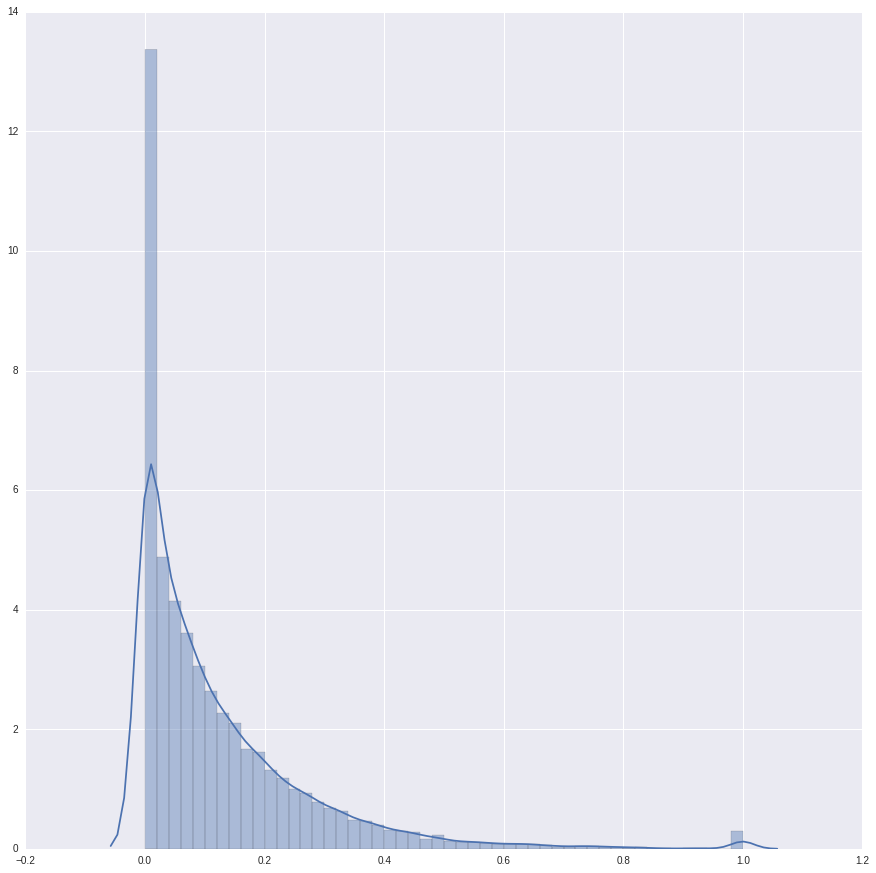

In [80]:
sns.distplot([x for l in dists for x in l])

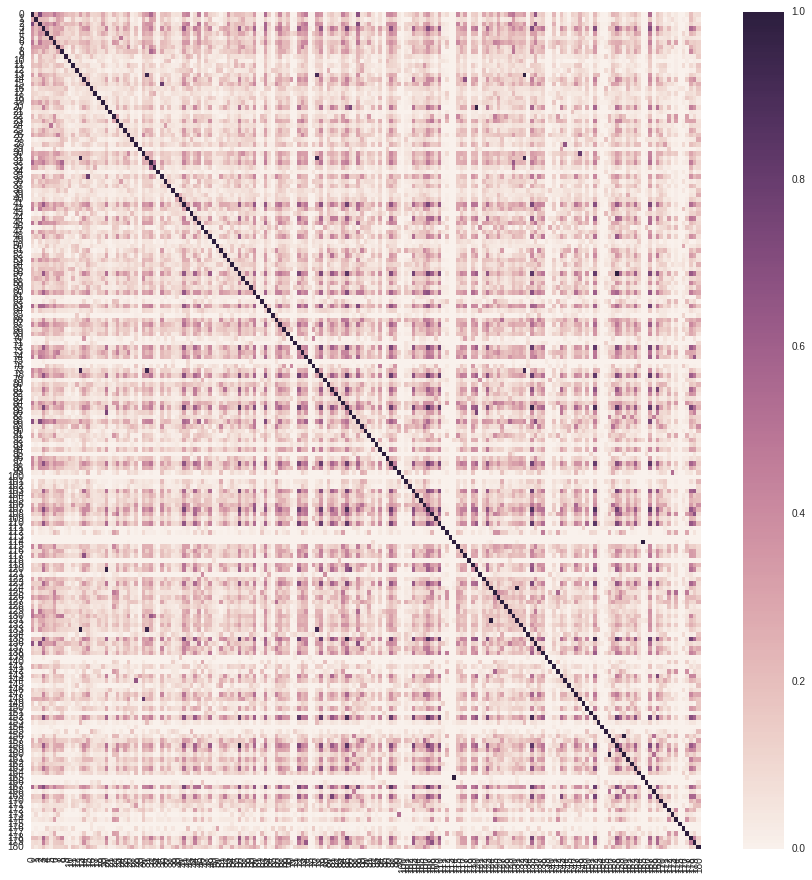

In [81]:
sns.heatmap(dists)

### Make clusters based on ngrams & words

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, metric="precomputed")

In [141]:
results = clusterer.fit_predict(dists)

In [142]:
r = {group: [] for group in results}    

for i, group in enumerate(results):
    r[group].append(clean_urls[i])

In [144]:
with open("urls-cluster.html", 'w') as f:
    f.write('<p>')
    for group in r:
        if group == -1:
            continue
            
        words = set(r[group][0]["words"])
        ngrams = set(r[group][0]["ngrams"])
        for url in r[group]:
            words = words & url["words"]
            ngrams = ngrams & url["ngrams"]
        f.write("Group:{}<br/>Words: {}<br/>Ngrams: {}<br/>".format(str(group), str(words), str(ngrams)))
        for url in r[group]:
            f.write("{}<br/>&nbsp;&nbsp;&nbsp;<a href={}>{}</a><br />".format(escape(url["title"])[:100] if url["title"] is not None else "NO TITLE" , url["url"], url["url"]))
        f.write('<br/><br/><br/>')
    f.write('</p>')

In [146]:
max(r)

1

In [147]:
xxx = r[1]

In [148]:
pd.DataFrame(list(zip(*[x["words"] for x in xxx])))

0             1              2           3               4    \
0            zooms   permutation    variational          ai  mathematically   
1    convolutional          cell   autoencoders   sejnowski        gaussian   
2        subregion         cells  convolutional      hinton            data   
3             code            l2            aes       brain      challenges   
4            steps      specific           daes        deep         methods   
5           object       cliques           rnns    geoffrey          kernel   
6              you       fearful            you     surpass           torch   
7   visualizations  connectivity           grus  artificial            deep   
8              vgg            l5          quite    learning            nips   
9    reinforcement      cortical           vaes    networks      profession   
10          github            et            vae       input        learning   
11    hierarchical           rsc  architectures     weights           field   
12          models      patterns       networks       cifar     uncertainty   
13            bool         units           node      neural          models   
14         weights            al            rnn     network         machine   
15     generalitat          mice      recurrent        nets          laning   
16           crops        neural        network     neurons     engineering   
17           image    excitatory         neural    machines             our   
18             upc       neurons         sample      google       processes   
19        proposal         logic  abbreviations          we              we   

            5             6             7              8               9    \
0         human          what           car    variational        software   
1           end       assumed            q2   autoencoders            data   
2      accuracy    describing   specialists        dropout          lustre   
3          data          said            ai       bayesian       marketing   
4         level        object       driving           nips             big   
5    approaches           you          nips       detector           intel   
6            dl           nlp          deep     distortion        solution   
7           you        vector  intelligence          mnist         webcast   
8            ai      language           aev    adversarial      enterprise   
9         chunk          read     automaker        anomaly  infrastructure   
10         test        trying      mobileye    classifiers          netapp   
11     learning    incidental    artificial          input       analytics   
12    flowchart             i       parking    uncertainty    applications   
13        model         often      learning         models           cloud   
14      dataset      megatron  autonomously     likelihood         netflix   
15       models          very         model         neural           cisco   
16          hpc          thia       piloted         linear      supermicro   
17  performance        tokens     maneuvers  approximation         nexenta   
18   algorithms  wittgenstein          audi             we       solutions   
19          dev         wrong       systems       datasets         storage   

       ...                 177           178              179           180  \
0      ...             framing          code     autoencoders           jnk   
1      ...                 gan            ai            arxiv           erk   
2      ...                  ai       improve       criticisms           pka   
3      ...                gans    leveraging          invited          pip2   
4      ...                  ml      leverage              you     variables   
5      ...                  am           you            brain           aci   
6      ...                 you      delivery         symposia             w   
7      ...        minimization          will             chen           mek   
8    